In [15]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import *
import cv2
import os
import matplotlib.pyplot as plt

In [16]:
path = "data/20181013_165101.jpg"
height, width = 240, 320

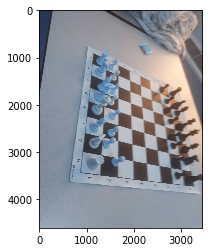

In [17]:
img = cv2.imread(path)
plt.imshow(img)

In [18]:
img.shape

(4608, 3456, 3)

In [19]:
corners_src = np.float32([[0, 0], [0, 320], [240, 320], [240, 0]])


In [20]:
def transform_img(img, corners_src):
    corners_dst = np.float32([[0, 0], [0, 320], [240, 320], [240, 0]])
    tfm = cv2.getPerspectiveTransform(corners_src, corners_dst)
    dst = cv2.warpPerspective(img, tfm, (240, 320))
    return dst
dst = transform_img(img, corners_src)

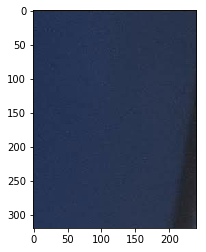

In [21]:
plt.imshow(dst)

# Mask Perspective Transformation

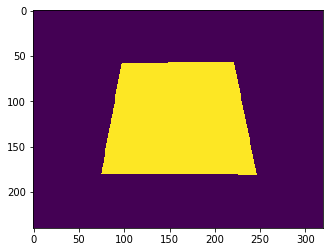

In [22]:
mask = np.load('y.npy')[0,:,:,0]
img = np.load('X.npy')[0]
plt.imshow(mask)

In [40]:
def get_unet():
    # predict all the mask AND the edges !
    inputs = Input((height, width, 3))

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    features_corner = MaxPooling2D()(drop5)
    features_corner = Conv2D(16, 3, activation = 'relu')(features_corner)
    features_corner = MaxPool2D()(features_corner)
    features_corner = Flatten()(features_corner)
    features_corner = Dense(64, activation = 'relu')(features_corner)
    features_corner = Dense(64, activation = 'relu')(features_corner)
    corners = Dense(8, activation = 'relu')(features_corner)
    
    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)


    # Changed to learn 2 features
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    masks = Conv2D(7, 1, activation = 'sigmoid')(conv9)
    
    
    model = Model(inputs = inputs, outputs = [masks, corners])

    model.compile(optimizer = Adam(lr = 1e-4), loss = ['binary_crossentropy', 'mean_squared_error'], metrics = ['accuracy'])

    return model
model = get_unet()

In [41]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_138 (Conv2D)             (None, 240, 320, 32) 896         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 240, 320, 32) 9248        conv2d_138[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 120, 160, 32) 0           conv2d_139[0][0]                 
__________________________________________________________________________________________________
conv2d_140

In [50]:
def conv_block(x, nb_filters = 64):
    y = Conv2D(nb_filters, 3)(x)
    y = BatchNormalization()(y)
    y = Activation(activation = 'relu')(y)
    y = MaxPool2D()(y)
    return y
def cnn_board():
    x = Input(shape = (240, 240, 16))
    y = conv_block(x)
    y = conv_block(y)
    y = conv_block(y)
    y = conv_block(y)
    y = Conv2D(32, 3, activation = 'relu')(y)
    y = Conv2D(32, 3, activation = 'relu')(y)
    y = Conv2D(7, 2, activation='sigmoid')(y)
    print(y.shape)
    
    model = Model(x, y)
    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer='Adam')
    model.summary()
    return model
model = cnn_board()

(?, 8, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 240, 240, 16)      0         
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 238, 238, 64)      9280      
_________________________________________________________________
batch_normalization_28 (Batc (None, 238, 238, 64)      256       
_________________________________________________________________
activation_28 (Activation)   (None, 238, 238, 64)      0         
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 119, 119, 64)      0         
_________________________________________________________________
conv2d_196 (Conv2D)          (None, 117, 117, 64)      36928     
_________________________________________________________________
batch_normalization_29 (Batc (None, 117, 117, 64)      256     